<a href="https://colab.research.google.com/github/eduardojdiniz/CichyWanderers/blob/434f62e9b2b6f4e7aa1463cecdd17a6a91ab997f/load_AlexNet_RDMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AlexNet RDMs

In [1]:
# Imports
import torch
from torchvision import transforms as trn
from torch.autograd import Variable as V
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
import glob
import numpy as np
import urllib
import os
from PIL import Image
from pathlib import Path

In [2]:
# AlexNet Definition
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model 

In [3]:
# Feature extraction code
def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model. Since we redefined model in a different
    way we have to rename the weights that were in the pretrained checkpoint.
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """

    model = alexnet()
    # Load checkpoint
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

    # Rename the checkpoint keys according to new definition
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    # initialize model with pretrained weights 
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

def get_activations_and_save(model, image_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # for all images in the list generate and save activations
    for image_file in tqdm(image_list):
        
        # open image
        img = Image.open(image_file)
        image_file_name = os.path.split(image_file)[-1].split(".")[0]

        # apply transformations before feeding to model
        input_img = V(resize_normalize(img).unsqueeze(0))
        if torch.cuda.is_available():
            input_img=input_img.cuda()
        x = model.forward(input_img)

        activations = []
        for i,feat in enumerate(x):
            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])


In [4]:
# get the paths to all the images in the stimulus set

image_dir = 'data/92_Image_Set/92images'

if not os.path.exists(image_dir):
    # Data download
    Path("data").mkdir(parents=True, exist_ok=True)
    !wget -qO data/data.zip -c https://osf.io/7vpyh/download
    !unzip -o data/data.zip -d data #unzip the files
    
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print('Total Number of Images: ', len(image_list))
cwd = os.getcwd() # get current working directory
save_dir = os.path.join(cwd, "model/activations_alexnet")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

######### load Alexnet initialized with pretrained weights ###################
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = os.path.join(cwd, "model/alexnet.pth")
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, checkpoint_path)
model = load_alexnet(checkpoint_path)
##############################################################################

######### get and save activations ################################
activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)
###################################################################

Archive:  data/data.zip
  inflating: data/92_Image_Set/ReadMe_92ImageSet.docx  
  inflating: data/92_Image_Set/92images/image_62.jpg  
  inflating: data/92_Image_Set/92images/image_74.jpg  
  inflating: data/92_Image_Set/92images/image_79.jpg  
  inflating: data/92_Image_Set/92images/image_73.jpg  
  inflating: data/92_Image_Set/92images/image_86.jpg  
  inflating: data/92_Image_Set/92images/image_92.jpg  
  inflating: data/92_Image_Set/92images/image_89.jpg  
  inflating: data/92_Image_Set/92images/image_90.jpg  
  inflating: data/92_Image_Set/92images/image_63.jpg  
  inflating: data/92_Image_Set/92images/image_82.jpg  
  inflating: data/92_Image_Set/92images/image_81.jpg  
  inflating: data/92_Image_Set/92images/image_91.jpg  
  inflating: data/92_Image_Set/92images/image_87.jpg  
  inflating: data/92_Image_Set/92images/image_77.jpg  
  inflating: data/92_Image_Set/92images/image_88.jpg  
  inflating: data/92_Image_Set/92images/image_64.jpg  
  inflating: data/92_Image_Set/92images/

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 92/92 [00:06<00:00, 15.25it/s]


In [5]:
cwd = os.getcwd() # get current working directory
activations_dir = os.path.join(cwd, "model/activations_alexnet")
def get_Model_RDM_dict(activations_dir=activations_dir):
    num_layers = 8  # number of layers in the model
    layers = []

    for i in range(num_layers):
      layers.append("layer" + "_" + str(i+1))

    Model_RDM_dict = {}

    # create RDM for each layer from activations
    for layer in layers:
        activation_files = glob.glob(activations_dir + '/*' + layer + '.npy')
        activation_files.sort()
        activations = []
        
        # Load all activations
        for activation_file  in activation_files:
            activations.append(np.load(activation_file))
        activations = np.array(activations)
        
        # calculate Pearson's distance for all pairwise comparisons 
        Model_RDM_dict[layer] = 1-np.corrcoef(activations)
        
    return Model_RDM_dict

In [6]:
Model_RDM_dict = get_Model_RDM_dict()

In [ ]:
layer_1 = Model_RDM_dict['layer_1']

In [18]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
import h5py
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

In [15]:
# Prepare the DSM MEG
!wget -qO data.zip -c https://osf.io/7vpyh/download

In [16]:
%%capture
!unzip -o data.zip #unzip the files

In [19]:
# Load MEG RDMs for each time point for all subjects all sessions
MEG_RDMs = loadmat("MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']

# average RDM across subjects and sessions
MEG_RDM_sub_averaged = np.mean(MEG_RDMs,axis=(0,1))
del MEG_RDMs

Text(0, 0.5, 'Decoding Accuracy')

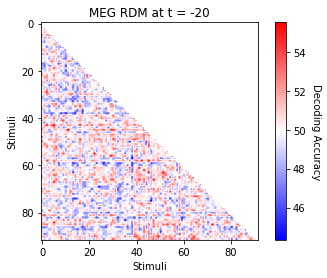

In [27]:
#@title visualize subject averaged MEG RDMs
timepoint = -20 #@param {type:"slider", min:-100, max:600, step:20}

# Load RDM at a given timepoint 
# +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
RDM = np.array(MEG_RDM_sub_averaged[timepoint+100])

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan
layer_1[np.triu_indices(layer_1.shape[0], 1)] = np.nan

# plot the RDM at given timepoint
plt.imshow(RDM,\
           cmap="bwr")
plt.title("MEG RDM at t = " + str(timepoint))
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decoding Accuracy', rotation=270)

In [23]:
####  run a simple regression model   ####

In [28]:
# converting the RDM to a vector
RDM_vect = np.asarray(RDM).reshape(-1) 
layer_1_vect = np.asarray(layer_1).reshape(-1) 

# delete the nan values
RDM_vect_nan = np.isnan(RDM_vect)
RDM_vect_not_nan = ~ RDM_vect_nan
RDM_vect_with_out_nan = RDM_vect[RDM_vect_not_nan]

layer_1_vect_nan = np.isnan(layer_1_vect)
layer_1_vect_not_nan = ~ layer_1_vect_nan
layer_1_vect_with_out_nan = layer_1_vect[layer_1_vect_not_nan]

In [29]:
print(len(layer_1_vect_with_out_nan))

4278


In [30]:
# running the regression
import numpy as np
from sklearn.linear_model import LinearRegression

y = RDM_vect_with_out_nan.reshape((-1, 1))
x = layer_1_vect_with_out_nan.reshape((-1, 1))

model = LinearRegression()
# y is the meg matrix, and x is the DCNN layer 1/2 matrix
model.fit(x, y)

model = LinearRegression().fit(x, y)

### printing the results

# r**2
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# intercept
print('intercept:', model.intercept_)

# slope
print('slope:', model.coef_)


##### I am getting an error: ValueError: Found input variables with 
# inconsistent numbers of samples: [4278, 4186]
# I will review it later


ValueError: ignored